Before continue ensure that the Libraries Importation cell runs without any errors. If so continue to run the rest of the file, otherwise assure all dependencies are properly installed. To do so, run in a terminal the following commands:
```
pip3 install matplotlib
pip3 install pandas
pip3 install openpyxl
```

In [2]:
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime
import pandas as pd
import numpy as np
from math import log, exp
import os

In [2]:
def database_compiler (start_year, end_year, export=False):
    dataframe = pd.DataFrame()
    for year in range(start_year, end_year, 5):
        filedata = pd.read_excel("RQAS TIET04200 - {}-{}.xlsx".format(year, year + 5))
        dataframe = dataframe.append(filedata, ignore_index=True)
    if export:
        dataframe.to_excel("RQAS TIET04200 - 1976-2021.xlsx", index=False)
    else:
        return dataframe

In [5]:
# Checks if the concatenated file exists, otherwise load each individual file and concatenate them:
if not os.path.exists("RQAS TIET04200 - 1976-2021.xlsx"):
    database_compiler(1976,2021, export=True)


dateparse = lambda dates: [datetime.strptime(date, "%d/%m/%Y") for d in dates]
# Loads the concatenated file:
df = pd.read_excel("RQAS TIET04200 - 1976-2021.xlsx")

In [6]:
# Convert strings containing dates to 'datetime' type:
df['Período DE'] = pd.to_datetime(df['Período DE'], infer_datetime_format=True)
df['Período ATE'] = pd.to_datetime(df['Período ATE'], infer_datetime_format=True)
df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], infer_datetime_format=True)
# Replace commas with periods to be able to convert 'string' to 'float' (on numeric values):
df['Valor']=df['Valor'].replace(',','.',regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10172 entries, 0 to 10171
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Período DE               10172 non-null  datetime64[ns]
 1   Período ATE              10172 non-null  datetime64[ns]
 2   Cod_Interaguas           10172 non-null  int64         
 3   Tipo Rede                10172 non-null  object        
 4   UGRHI                    10172 non-null  object        
 5   Código Ponto             10172 non-null  object        
 6   Status Ponto             10172 non-null  object        
 7   Data Coleta              10172 non-null  datetime64[ns]
 8   Hora Coleta              10172 non-null  object        
 9   Parametro                10172 non-null  object        
 10  Sinal                    1418 non-null   object        
 11  Valor                    10172 non-null  object        
 12  Unidade                  10172 n

In [7]:
df['Parametro'].unique()

array(['pH', 'Temperatura da Água', 'Temperatura do Ar',
       'Subst. Tensoat. reagem c/ Azul Metileno', 'Turbidez',
       'Fenóis Totais', 'Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito',
       'Nitrogênio-Nitrato', 'Nitrogênio Amoniacal',
       'Oxigênio Dissolvido', 'DBO (5, 20)', 'DQO',
       'Sólido Dissolvido Total', 'Sólido Total', 'Sólido Volátil Total',
       'Fósforo Total', 'Cloreto Total', 'Crômio Total', 'Manganês Total',
       'Ferro Total', 'Ferro Dissolvido', 'Níquel Total', 'Cobre Total',
       'Zinco Total', 'Coliformes Totais - TTM',
       'Coliformes Termotolerantes', 'Estanho Total', 'Bário Total',
       'Mercúrio Total', 'Chumbo Total', 'Coloração',
       'Chuvas nas últimas 24h', 'Sólido Fixo', 'Cádmio Total',
       'Sólido Suspenso Total', 'Condutividade', 'Fósforo-Ortofosfato',
       'Alumínio Total', 'Sulfato Total', 'Arsênio Total',
       'Carbono Orgânico Total', 'Sólido Dissolvido Fixo',
       'Alumínio Dissolvido', 'Cobre Dissolvido',
       'C

In [23]:
# Creates a df copy for a given parameter to avoid the case where changing the original df also changes these:
def df_by_parameter(parameter):
    df_slice = df.loc[df['Parametro'] == parameter , ['Data Coleta', 'Valor']].copy()
    df_slice['Valor'] = pd.to_numeric(df_slice['Valor'])
    return df_slice
# Creates a df copy for each relevant parameter:
df_pH = df_by_parameter('pH')
df_Fos = df_by_parameter('Fósforo Total')
df_DBO = df_by_parameter('DBO (5, 20)')
df_Nit = df_by_parameter('Nitrogênio Total')
df_ColFec = df_by_parameter('Coliformes Totais - TTM')
df_Turb = df_by_parameter('Turbidez')
df_Res = df_by_parameter('Sólido Total')
def_OxDis = df_by_parameter('Oxogênio Dissolvido')

df_TempAgua = df_by_parameter('Temperatura da Água')
df_TempAr = df_by_parameter('Temperatura do Ar')

df_DifTemp = pd.DataFrame()
df_DifTemp['Data Coleta'] = df_TempAgua['Data Coleta']
#df_DifTemp.merge(df_TempAgua, how='inner', on='Data Coleta')
df_TempAgua.merge(df_TempAr, how='inner', on='Data Coleta')
#df_DifTemp['Diferença de Temperatura'] = df_DifTemp[]
df_TempAr.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 72 to 10127
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data Coleta  301 non-null    datetime64[ns]
 1   Valor        301 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [28]:
#df_DifTemp.set_index('Data Coleta').join(df_TempAgua.set_index('Data Coleta'))
df_TempAgua.set_index('Data Coleta').join(df_TempAr.set_index('Data Coleta'), lsuffix=" Água", rsuffix=" Ar")
df_TempAgua.head()



,Data Coleta,Valor
36,1978-01-01,21.0
37,1978-01-02,25.0
38,1978-01-03,25.0
39,1978-01-04,22.0
40,1978-01-05,24.0


In [59]:
df_pH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 0 to 10129
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data Coleta  305 non-null    datetime64[ns]
 1   Valor        305 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.1 KB


In [3]:
def iqa_reference_compiler ():
    dfs_ref = []
    for n in range(1,10):
        filedata = pd.read_csv("iqa-q{}-reference.csv".format(n))
        dfs_ref.append(filedata)
    return dfs_ref

q1_ref, q2_ref, q3_ref, q4_ref, q5_ref, q6_ref, q7_ref, q8_ref, q9_ref = iqa_reference_compiler()

In [ ]:
plt.plot(q1_ref['x'], q1_ref[' y'])
plt.xscale('log')
plt.plot()
plt.show()

In [12]:
def calculate_q1(ColFec):
    if 1 <= ColFec <= 10**5:
        return 98.2403 - 34.7145*log(ColFec, 10) + 2.6142*log(ColFec, 10)**2 + 0.1078*log(ColFec, 10)
    elif ColFec > 10**5:
        return 3

    else:
        raise ValueError("'ColFec' values must be higher than 1")

def calculate_q2(pH):
    if 0 <= pH < 2:
        return 2
    elif pH < 6.9:
       return -37.1085 + 41.91277*pH - 15.7043*pH**2 + 2.417486*pH**3 - 0.091252*pH**4
    elif pH < 7.1:
        return -4.69365 - 21.4593*pH - 68.4561*pH**2 + 21.638886*pH**3 - 1.59165*pH**4
    elif pH < 12:
        return -7698.19 + 3262.031*pH - 499.494*pH**2 + 33.1551*pH**3 - 0.810613*pH**4
    elif pH <= 14:
        return 3
    else:
        raise ValueError("'pH' values must be in range 0-14")

def calculate_q3(DBO):
    if 0 <= DBO <= 30:
        return 100.9571 - 10.7121*DBO + 0.49544*DBO**2 - 0.011167*DBO**3 + 0.0001*DBO**4
    elif DBO > 30:
        return 2
    else:
        raise ValueError("'DBO' values must be higher than 0")

def calculate_q4(Nit):
    if 0 <= Nit <= 100:
        return 96.81717 - 5.0618*Nit + 0.124443*Nit**2 - 0.001424*Nit**3 + 0.000006*Nit**4
    elif Nit > 100:
        return 1
    else:
        raise ValueError("'Nit' values must be higher than 0")

def calculate_q5(Fos):
    if 0 <= Fos <= 10:
        return 92.62766 - 61.5585*Fos + 17.43021*Fos**2 - 2.08356*Fos**3 + 0.087126*Fos**4
    elif Fos > 10:
        return 1
    else:
        raise ValueError("'Nit' values must be higher than 0")

def calculate_q6(DifTemp):
    if -5 <= DifTemp <= 15:
        return 86.57492 - 3.48716*DifTemp - 1.39086*DifTemp**2 + 0.141478*DifTemp**3 - 0.003704*DifTemp**4
    elif DifTemp > 15:
        return 9
    else:
        raise ValueError("Cannot calculate for 'DifTemp' values below -5")

def calculate_q7(Turb):
    if 0 <= Turb <= 100:
        return 97.92091 - 2.2745*Turb + 0.028129*Turb**2 - 0.000139*Turb**3
    elif Turb > 100:
        return 5
    else:
        raise ValueError("'Turb' values must be higher than 0") 

def calculate_q8(Res):
    if 0 <= Res <= 500:
        return 86.23847 - 0.028473*Res - 0.000165*Res**2
    elif Res > 500:
        return 32
    else:
        raise ValueError("'Res' values must be higher than 0")

def calculate_q9(OxDis, Temp, altitude):
    if 0 <= OxDis <= 140:
        # Oxigênio Dissolvido em condição saturada (função da temepratura da água):
        value_OD = 14.652 - 4.1022*1e-1*Temp + 7.9910*1e-3*Temp**2 - 7.774*1e-5*Temp**3
        # Oxigênio Dissolvido em condição saturada corrigindo com a altitude:
        value_corrected_OD = (1 - altitude/9450)*value_OD
        # Porcentagem de Saturação de Oxigênio (PSO):
        value_PSO = (value_OD / value_corrected_OD)*100

        return 1.129098 + 0.203149*value_PSO + 0.021209*value_PSO**2 - 0.000136*value_PSO**3
    elif OxDis > 140:
        return 47
    else:
        raise ValueError("'OxDis' values must be higher than 0")

In [20]:
# Calculate q1 from 'ColFec':
values_ColFec = np.linspace(1, 1e5, 50)
values_q1 = np.fromiter( (calculate_q1(ColFec) for ColFec in values_ColFec) , float)
# Calculate q2 from 'pH':
values_pH = np.linspace(2, 12, 50)
values_q2 = np.fromiter( (calculate_q2(pH) for pH in values_pH) , float)
# Calculate q3 from 'DBO':
values_DBO = np.linspace(0, 30, 50)
values_q3 = np.fromiter( (calculate_q3(DBO) for DBO in values_DBO) , float)
# Calculate q4 from 'Nit':
values_Nit = np.linspace(0, 100, 50)
values_q4 = np.fromiter( (calculate_q4(Nit) for Nit in values_Nit) , float)
# Calculate q5 from 'Fos':
values_Fos = np.linspace(0, 10, 50)
values_q5 = np.fromiter( (calculate_q5(values_Fos) for values_Fos in values_Fos) , float)
# Calculate q6 from 'DifTemp':
values_DifTemp = np.linspace(-5, 15, 50)
values_q6 = np.fromiter( (calculate_q6(DifTemp) for DifTemp in values_DifTemp), float)
# Calculate q7 from 'Turb':
values_Turb = np.linspace(0, 100, 50)
values_q7 = np.fromiter( (calculate_q7(Turb) for Turb in values_Turb) , float)
# Calculate q8 from 'Res':
values_Res = np.linspace(0, 500, 50)
values_q8 = np.fromiter( (calculate_q8(Res) for Res in values_Res) , float)
# Calculate q9 from 'OxDis':
values_OxDis = np.linspace(0, 140, 50)
values_q9 = np.fromiter( (calculate_q9(OxDis, 20, 760) for OxDis in values_OxDis) , float)

In [21]:
print(values_q9)

[99.13629541 99.13629541 99.13629541 99.13629541 99.13629541 99.13629541
 99.13629541 47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.         47.         47.         47.         47.
 47.         47.        ]


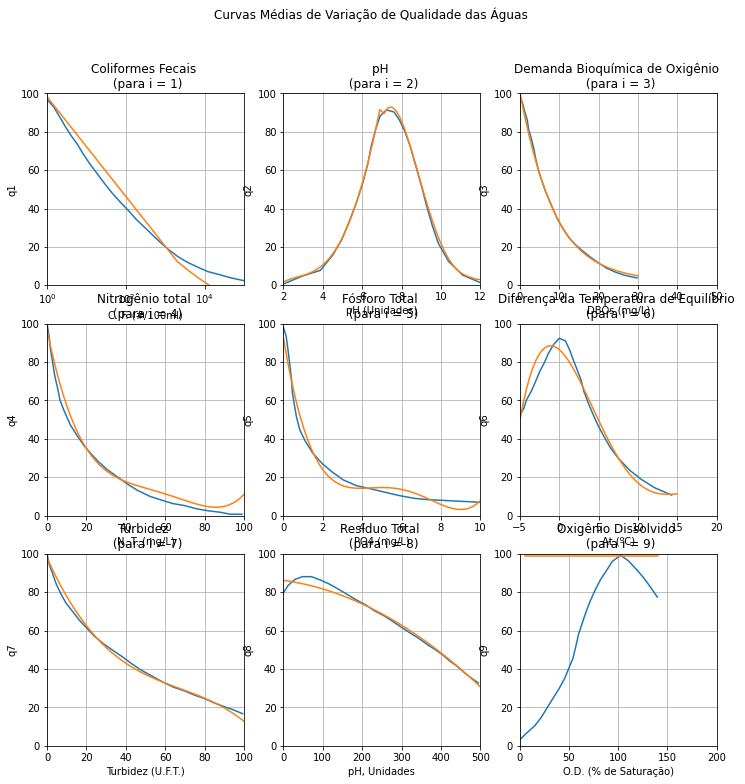

In [14]:


plt.figure(figsize=(12, 12))
plt.suptitle("Curvas Médias de Variação de Qualidade das Águas")

plt.subplot(3, 3, 1)
plt.title("Coliformes Fecais \n (para i = 1)")
plt.plot(q1_ref['x'], q1_ref[' y'], label="Referência")
plt.plot(values_ColFec, values_q1, label="Modelo")
plt.xscale('log')
plt.xlabel("C. F. (#/100ml)")
plt.ylabel("q1")
plt.xlim(1, 1e5)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 2)
plt.title("pH \n (para i = 2)")
plt.plot(q2_ref['x'], q2_ref[' y'], label="Referência")
plt.plot(values_pH, values_q2, label="Modelo")
plt.xlabel("pH (Unidades)")
plt.ylabel("q2")
plt.xlim(2, 12)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 3)
plt.title("Demanda Bioquímica de Oxigênio \n (para i = 3)")
plt.plot(q3_ref['x'], q3_ref[' y'], label="Referência")
plt.plot(values_DBO, values_q3, label="Modelo")
plt.xlabel("DBOs (mg/L)")
plt.ylabel("q3")
plt.xlim(0, 50)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 4)
plt.title("Nitrogênio total \n (para i = 4)")
plt.plot(q4_ref['x'], q4_ref[' y'], label="Referência")
plt.plot(values_Nit, values_q4, label="Modelo")
plt.xlabel("N. T. (mg/L)")
plt.ylabel("q4")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 5)
plt.title("Fósforo Total \n (para i = 5)")
plt.plot(q5_ref['x'], q5_ref[' y'], label="Referência")
plt.plot(values_Fos, values_q5, label="Modelo")
plt.xlabel("PO4 (mg/L)")
plt.ylabel("q5")
plt.xlim(0, 10)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 6)
plt.title("Diferença da Temperatura de Equilíbrio \n (para i = 6)")
plt.plot(q6_ref['x'], q6_ref[' y'], label="Referência")
plt.plot(values_DifTemp, values_q6, label="Modelo")
plt.xlabel("At (ºC)")
plt.ylabel("q6")
plt.xlim(-5, 20)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 7)
plt.title("Turbidez \n (para i = 7)")
plt.plot(q7_ref['x'], q7_ref[' y'], label="Referência")
plt.plot(values_Turb, values_q7, label="Modelo")
plt.xlabel("Turbidez (U.F.T.)")
plt.ylabel("q7")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 8)
plt.title("Resíduo Total \n (para i = 8)")
plt.plot(q8_ref['x'], q8_ref[' y'], label="Referência")
plt.plot(values_Res, values_q8, label="Modelo")
plt.xlabel("pH, Unidades")
plt.ylabel("q8")
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.grid()

plt.subplot(3, 3, 9)
plt.title("Oxigênio Dissolvido \n (para i = 9)")
plt.plot(q9_ref['x'], q9_ref[' y'], label="Referência")
plt.plot(values_OxDis, values_q9, label="Modelo")
plt.xlabel("O.D. (% de Saturação)")
plt.ylabel("q9")
plt.xlim(0, 200)
plt.ylim(0, 100)
plt.grid()

plt.show()


Fonte: http://pnqa.ana.gov.br/indicadores-indice-aguas.aspx

In [ ]:
def calculate_IQA (q_list, w_list):
    q1, q2, q3, q4, q5, q6, q7, q8, q9 = q_list
    w1, w2, w3, w4, w5, w6, w7, w8, w9 = w_list
    iqa = 1
    for q, w in zip(q_list, w_list):
        iqa *= q**w
    return iqa

def classify_IQA (value, state):
    if state in ['BA', 'CE', 'ES', 'GO', 'MS', 'PB', 'PE', 'SP']:
        if  0 < value < 19: return 'Péssima'
        elif value < 36: return 'Ruim'
        elif value < 51: return 'Razoável'
        elif value < 79: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    elif state in ['AL', 'MG', 'MT', 'PR', 'RJ', 'RN', 'RS']:
        if  0 < value < 25: return 'Péssima'
        elif value < 50: return 'Ruim'
        elif value < 70: return 'Razoável'
        elif value < 90: return 'Boa'
        elif value < 100: return 'Ótima'
        else: raise ValueError('IQA values must be in range 0-100')
    else: raise ValueError('State does not use IQA classification')


In [ ]:
wi= [0.10, 0.12, 0.10, 0.10, 0.15, 0.10, 0.08, 0.17]